# Error Analysis

Take a look at the predictions and errors made by your best performing model. 

With a structured approach, describe if you see any patterns made. 
- Is there a word type that occurs often that throws the model off? 
- Is there something about sentence length? 
- Are all sentences of class x predicted as class y? 
- For the task at hand, is a high accuracy, recall or F1 score more important? 
  
If you have a clear idea of the strenghts and weaknesses of your model, you can use this to base your advice on towards the client. This task contributes to the excellent criteria for ILO 4.2 and the good criteria for 6.0.

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf 

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import accuracy_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification

nltk.download('punkt')
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

c:\Users\r_bor\anaconda3\envs\ml-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\r_bor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load analysis dataset and create predictions

In [2]:
predictions = pd.read_csv('merged_fix.csv')
banijay = pd.read_csv('../../data/data_banijay/processed/Robinson22_structure_cleaned.csv')

#### preprocess predictions data

In [3]:
word_replacements = {
    'grief': 'sadness',
    'Scared': 'fear',
}

# Replace the wrong prediction classes in the dataset
predictions['predictions'] = predictions['predictions'].replace(word_replacements)

# Extract episode number from 'video_filename' column
predictions['episode_number'] = predictions['video_filename'].apply(lambda x: re.search(r'ER\d+_AFL(\d+)', x).group(1)).astype(int)

#### preprocess banijay data

In [4]:
# add fragment count to each episode
banijay['fragment'] = banijay.groupby('Episode name').cumcount() 

#### merge datasets and preprocess data

In [5]:
# merge datasets
merged_df = pd.merge(predictions, banijay, left_on=['episode_number', 'fragment'], right_on=['Episode name', 'fragment'], how='inner')

# create true_emotion
merged_df['true_emotion'] = merged_df.apply(lambda row: ' '.join(set(str(row['predictions']).split()) & set(str(row['mapped_emotion']).split())) 
                                            if str(row['predictions']) in str(row['mapped_emotion']) else str(row['mapped_emotion']), axis=1)

# split true_emotion column by comma
merged_df = merged_df.assign(true_emotion=merged_df['true_emotion'].str.replace(',', '').str.strip().str.split()).explode('true_emotion').reset_index(drop=True)

# create subset with necessary columns only
merged_df = merged_df[['episode_number', 'fragment', 'text', 'predictions', 'mapped_emotion', 'true_emotion']].dropna()


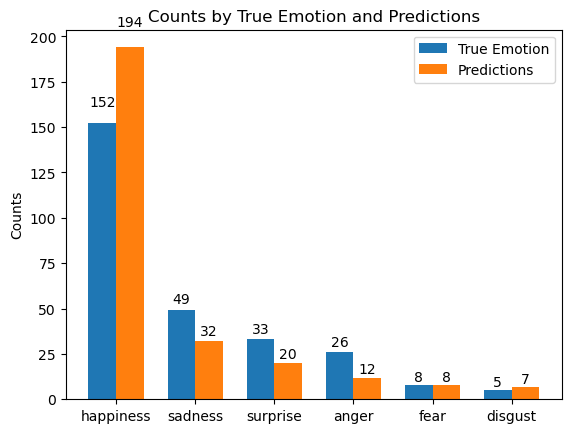

In [6]:
# Get the count of each unique true_emotion and predictions
true_emotion_counts = merged_df['true_emotion'].value_counts()
predictions_counts = merged_df['predictions'].value_counts()

# create barplot
N = len(true_emotion_counts)
ind = np.arange(N) 
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind, true_emotion_counts.values, width, label='True Emotion')
rects2 = ax.bar(ind + width, predictions_counts.values, width, label='Predictions')
ax.set_ylabel('Counts')
ax.set_title('Counts by True Emotion and Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(true_emotion_counts.index)
ax.legend()

for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.show()

## Word type analysis 


In [7]:
### Generated by ChatGPT using the prompt: 
### "Please map the POS Tags to their respective word type categories."

def get_word_type_category(pos_tag):
    """Function to get the word type category of a POS tag."""
    word_type_categories = {
        'CC': 'Conjunction',
        'CD': 'Number',
        'DT': 'Determiner',
        'EX': 'Foreign',
        'FW': 'Foreign',
        'IN': 'Preposition',
        'JJ': 'Adjective',
        'JJR': 'Adjective',
        'JJS': 'Adjective',
        'LS': 'List item marker',
        'MD': 'Modal',
        'NN': 'Noun',
        'NNS': 'Noun',
        'NNP': 'Noun',
        'NNPS': 'Noun',
        'PDT': 'Determiner',
        'POS': 'Possessive',
        'PRP': 'Pronoun',
        'PRP$': 'Pronoun',
        'RB': 'Adverb',
        'RBR': 'Adverb',
        'RBS': 'Adverb',
        'RP': 'Particle',
        'SYM': 'Symbol',
        'TO': 'to',
        'UH': 'Interjection',
        'VB': 'Verb',
        'VBD': 'Verb',
        'VBG': 'Verb',
        'VBN': 'Verb',
        'VBP': 'Verb',
        'VBZ': 'Verb',
        'WDT': 'Determiner',
        'WP': 'Pronoun',
        'WP$': 'Pronoun',
        'WRB': 'Adverb'
    }
    return word_type_categories.get(pos_tag, pos_tag)

In [8]:
def specific_word_type_analysis(df, emotions, wrong_predictions=True):
    '''Count the number of words for each word type for specific emotions in the dataset. 
    The function tokenizes the words, performs
    POS tagging, normalizes the counts, and plots the normalized counts for the given emotions.
    
    Parameters:
    - df (DataFrame): The input DataFrame.
    - emotions (list of str): The list of emotions to analyze.
    - wrong_predictions (bool): If True, the function will consider the wrongly predicted emotions, 
                                otherwise the correct predictions.
    '''
    all_pos_counts = {emotion: Counter() for emotion in emotions}
    total_word_counts = Counter()

    for emotion in emotions:
        if wrong_predictions:
            subset = df[(df['true_emotion'] == emotion) & (df['true_emotion'] != df['predictions'])]
            title = f'Word Type Analysis for wrong Predictions'
        else: 
            subset = df[(df['true_emotion'] == emotion) & (df['true_emotion'] == df['predictions'])]
            title = f'Word Type Analysis for correct Predictions'
        
        word_pos_tags = nltk.pos_tag_sents([sentence.split() for sentence in subset['text']])
        pos_counts = Counter([pos for sent_pos_tags in word_pos_tags for word, pos in sent_pos_tags])
        all_pos_counts[emotion] += pos_counts
        total_word_counts[emotion] += sum(pos_counts.values())

    non_empty_pos_tags = set()
    for emotion_counts in all_pos_counts.values():
        non_empty_pos_tags.update(emotion_counts.keys())

    num_pos_tags = len(non_empty_pos_tags)

    plt.figure(figsize=(8, 4 * num_pos_tags))

    for j, pos_tag in enumerate(non_empty_pos_tags):
        plt.subplot(num_pos_tags, 1, j + 1)
        for i, emotion in enumerate(emotions):
            top_n_pos_counts = dict(sorted(all_pos_counts[emotion].items(), key=lambda item: item[1], reverse=True))
            normalized_counts = {tag: count / total_word_counts[emotion] for tag, count in top_n_pos_counts.items()}
            pos_counts_for_tag = {tag: count for tag, count in normalized_counts.items() if tag == pos_tag}

            if pos_tag in pos_counts_for_tag:
                plt.bar(i, pos_counts_for_tag[pos_tag], width=0.2, label=emotion)

        plt.xlabel('Emotion')
        plt.ylabel('Normalized Frequency')
        pos_tag_name = get_word_type_category(pos_tag)
        plt.title(f'Word Type: {pos_tag_name}')
        plt.xticks(range(len(emotions)), emotions)
        plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
def word_type_analysis(df, emotions, wrong_predictions=True):
    '''Count the number of words for each word type category for specific emotions in the dataset. 
    The function tokenizes the words, performs
    POS tagging, normalizes the counts, and plots the normalized counts for the given emotions.
    
    Parameters:
    - df (DataFrame): The input DataFrame.
    - emotions (list of str): The list of emotions to analyze.
    - wrong_predictions (bool): If True, the function will consider the wrongly predicted emotions, 
                                otherwise the correct predictions.
    '''
    all_word_type_counts = {emotion: Counter() for emotion in emotions}
    total_word_counts = Counter()

    for emotion in emotions:
        if wrong_predictions:
            subset = df[(df['true_emotion'] == emotion) & (df['true_emotion'] != df['predictions'])]
            title = f'Word Type Analysis for wrong Predictions'
        else: 
            subset = df[(df['true_emotion'] == emotion) & (df['true_emotion'] == df['predictions'])]
            title = f'Word Type Analysis for correct Predictions'
        
        word_pos_tags = nltk.pos_tag_sents([sentence.split() for sentence in subset['text']])
        word_type_counts = Counter([get_word_type_category(pos) for sent_pos_tags in word_pos_tags for word, pos in sent_pos_tags])
        all_word_type_counts[emotion] += word_type_counts
        total_word_counts[emotion] += sum(word_type_counts.values())

    non_empty_word_type_categories = set()
    for emotion_counts in all_word_type_counts.values():
        non_empty_word_type_categories.update(emotion_counts.keys())

    data = {emotion: [all_word_type_counts[emotion][word_type] / total_word_counts[emotion] if word_type in all_word_type_counts[emotion] else 0
                      for word_type in non_empty_word_type_categories] 
            for emotion in emotions}
    df_plot = pd.DataFrame(data, index=list(non_empty_word_type_categories))

    plt.figure() 
    ax = df_plot.plot(kind='bar', rot=90, width=0.8)
    ax.set_title(title)
    ax.set_xlabel('Word Type Category')
    ax.set_ylabel('Normalized Frequency')
    ax.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [10]:
true_emotions = merged_df['true_emotion'].unique()

### Is there a word type that occurs often that throws the model off? 

#### Word type analysis for wrong predicted fragments

<Figure size 640x480 with 0 Axes>

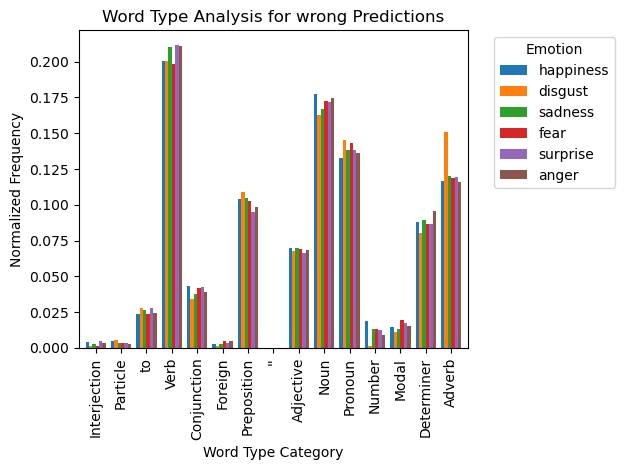

In [11]:
word_type_analysis(merged_df, true_emotions, wrong_predictions=True)


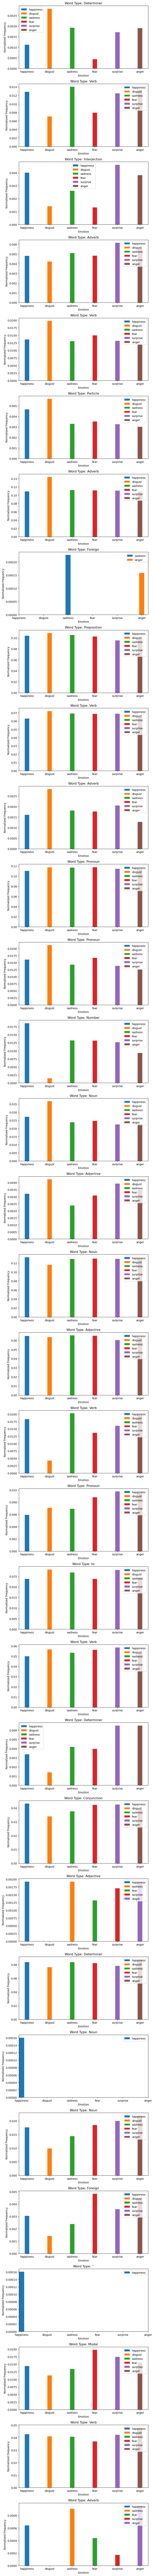

In [12]:
specific_word_type_analysis(merged_df, true_emotions, wrong_predictions=True)

#### Word type analysis for correct predicted fragments

<Figure size 640x480 with 0 Axes>

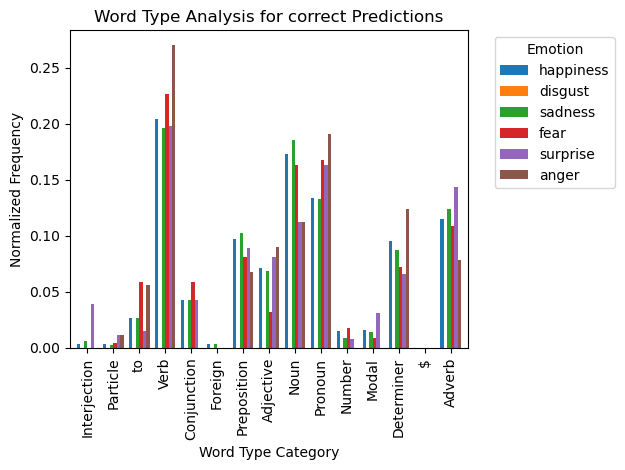

In [13]:
word_type_analysis(merged_df, true_emotions, wrong_predictions=False)

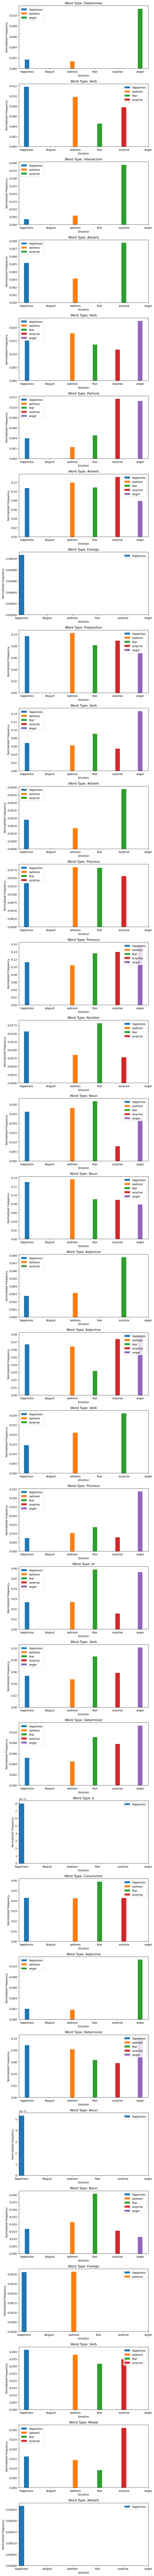

In [14]:
specific_word_type_analysis(merged_df, true_emotions, wrong_predictions=False)

## Term Frequency Analysis

### What words are the most frequent in each emotion?

In [15]:
def word_frequency_analysis(df, emotion, num_words=10, wrong_predictions=True):
    '''Perform word type analysis (find the most frequent words) 
    for a specific emotion in the dataset. The function tokenizes the words and 
    plots the most frequent word types for the given emotion.
    
    Parameters:
    - df (DataFrame): The input DataFrame.
    - emotion (str): The emotion to analyze.
    - num_words (int): The number of words to plot.
    - wrong_predictions (bool): If True, the function will consider the wrongly predicted emotions, 
                                otherwise the correct predictions.
    '''
    stop_words = set(stopwords.words('english'))
    
    if wrong_predictions == True:
        subset = df[(df['true_emotion'] == emotion) & (df['true_emotion'] != df['predictions'])]
        title = f'Most Common Words for {emotion} (Wrong Predictions)'
    else: 
        subset = df[(df['true_emotion'] == emotion) & (df['true_emotion'] == df['predictions'])]
        title = f'Most Common Words for {emotion} (Correct Predictions)'
    
    word_types = [word for sentence in subset['text'] for word in sentence.split() if word.lower() not in stop_words]
    word_type_counts = Counter(word_types)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[pair[0] for pair in word_type_counts.most_common(num_words)],
                    y=[pair[1] for pair in word_type_counts.most_common(num_words)])
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    

In [16]:
true_emotions = merged_df['true_emotion'].unique()

#### Word frequency analysis for correctly predicted emotions

Find out what the most common words are that were predicted correctly 

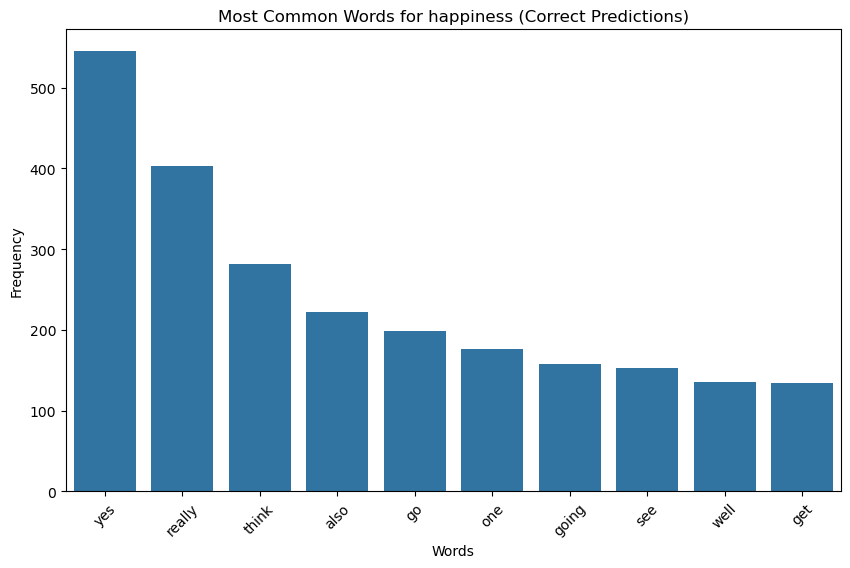

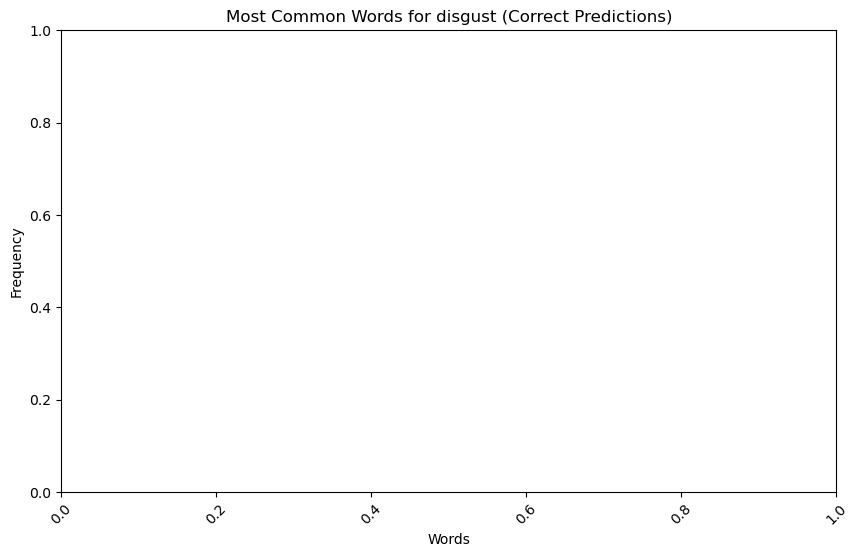

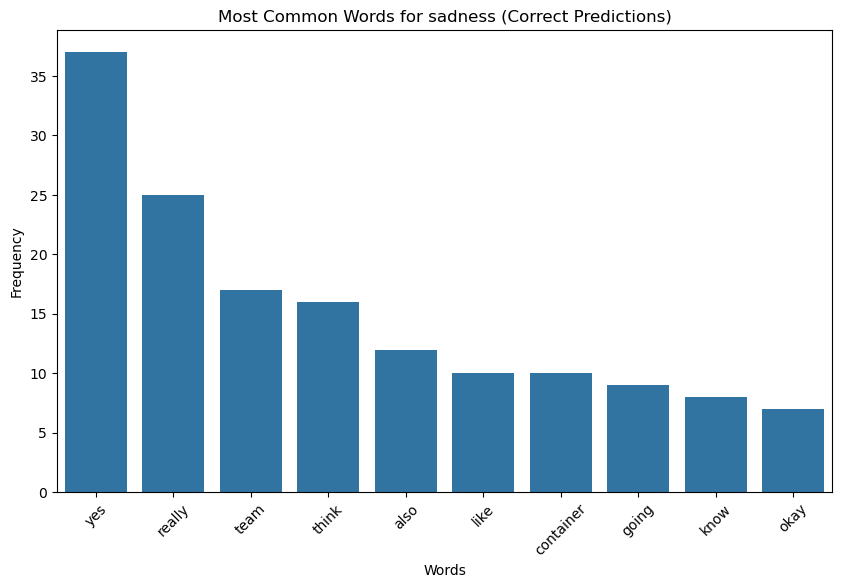

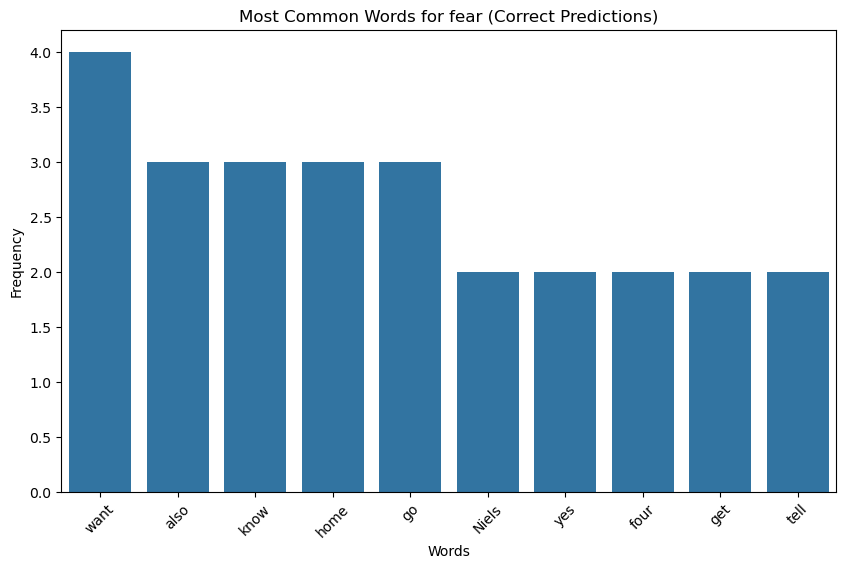

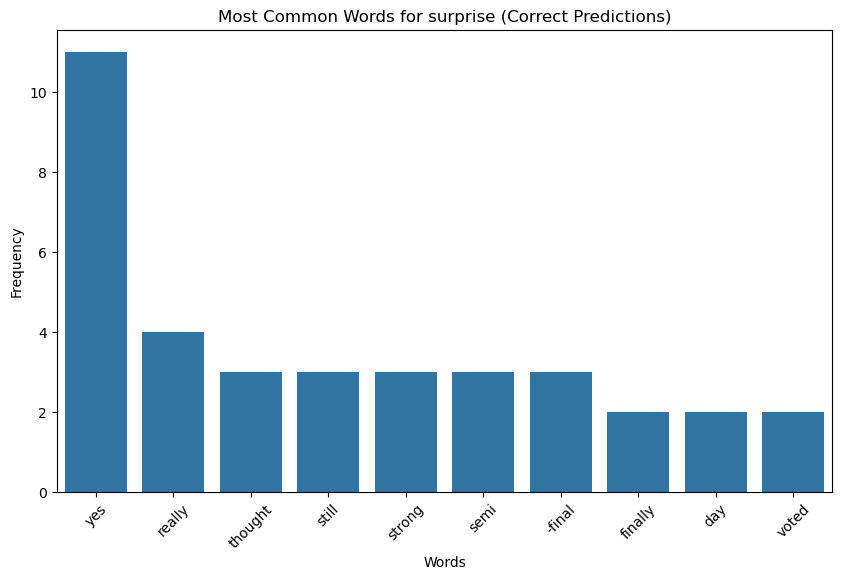

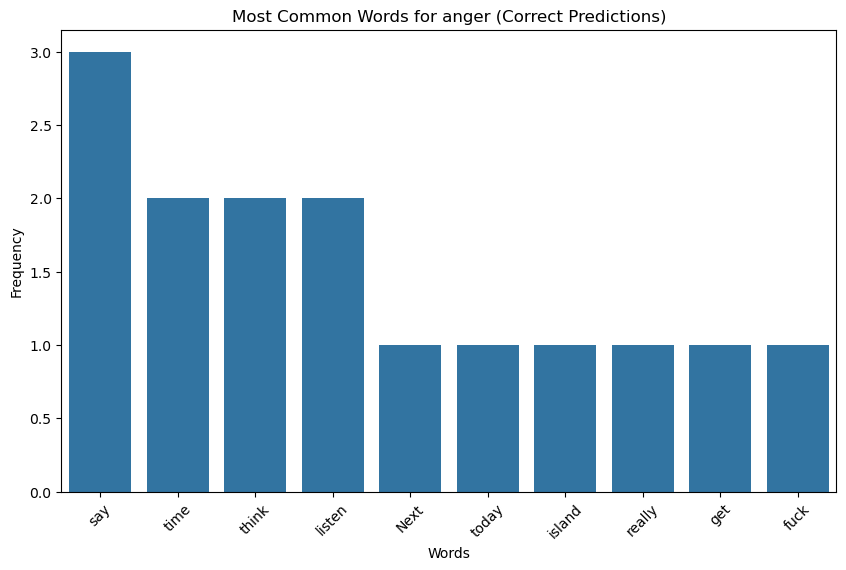

In [17]:
for emotion in true_emotions:
    word_frequency_analysis(merged_df, emotion, num_words=10, wrong_predictions=False)

#### Word frequency analysis for wrongly predicted emotions

Find out what the most common words are that were predicted wrongly.

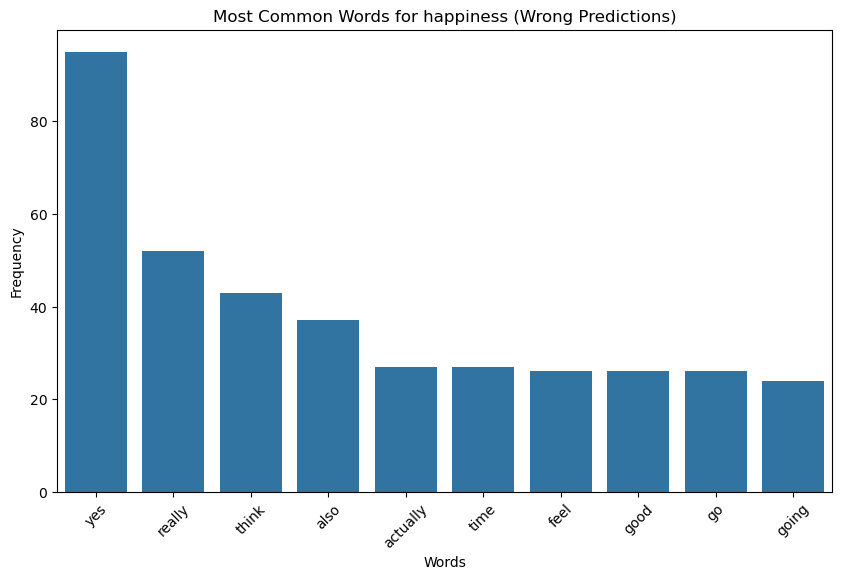

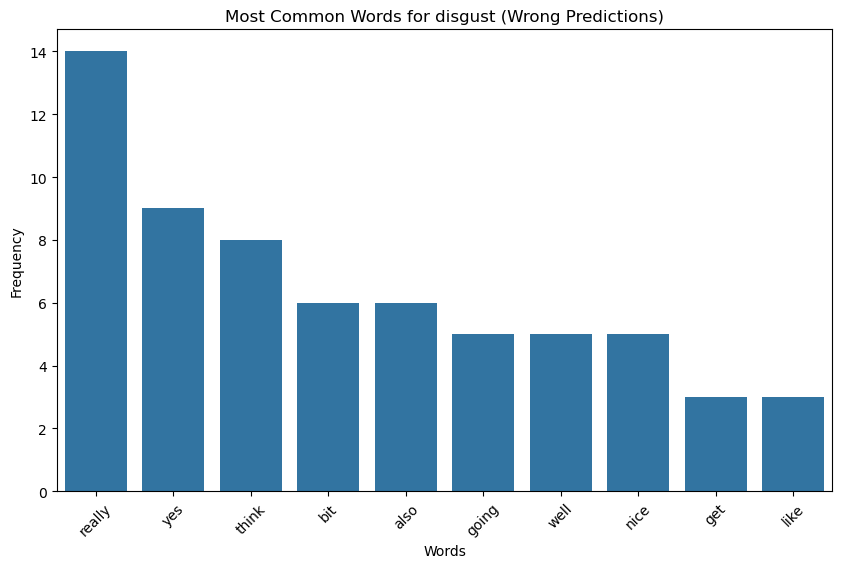

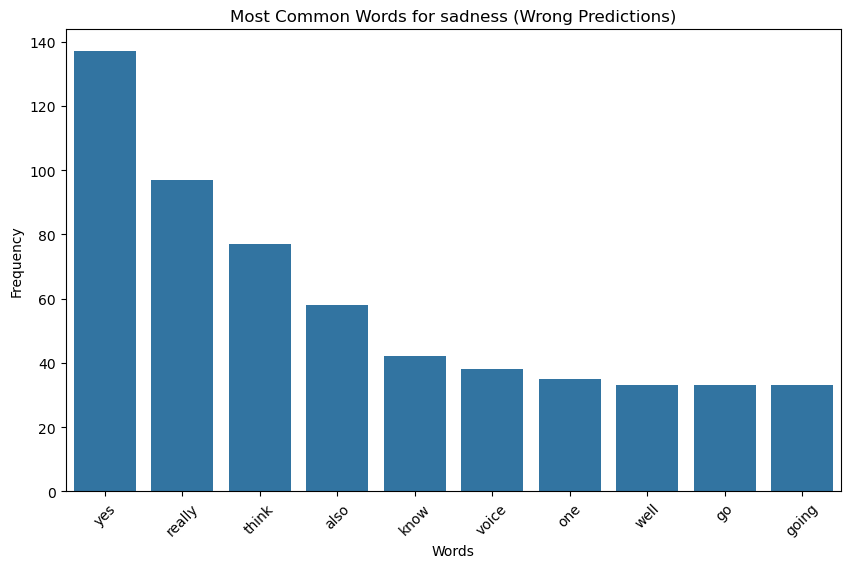

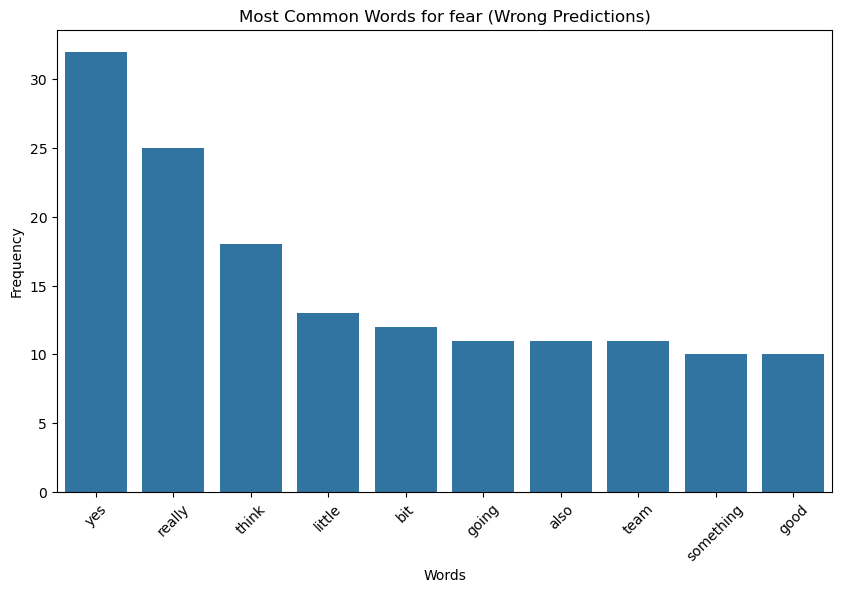

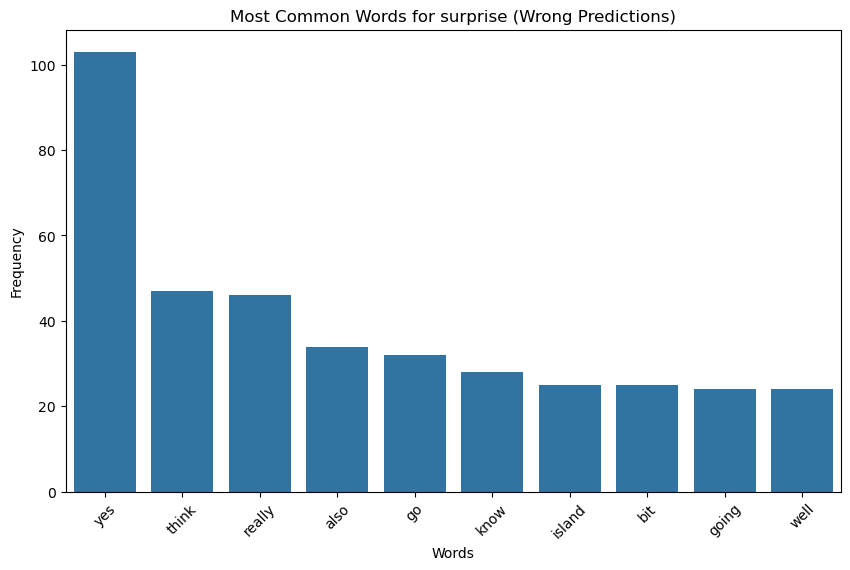

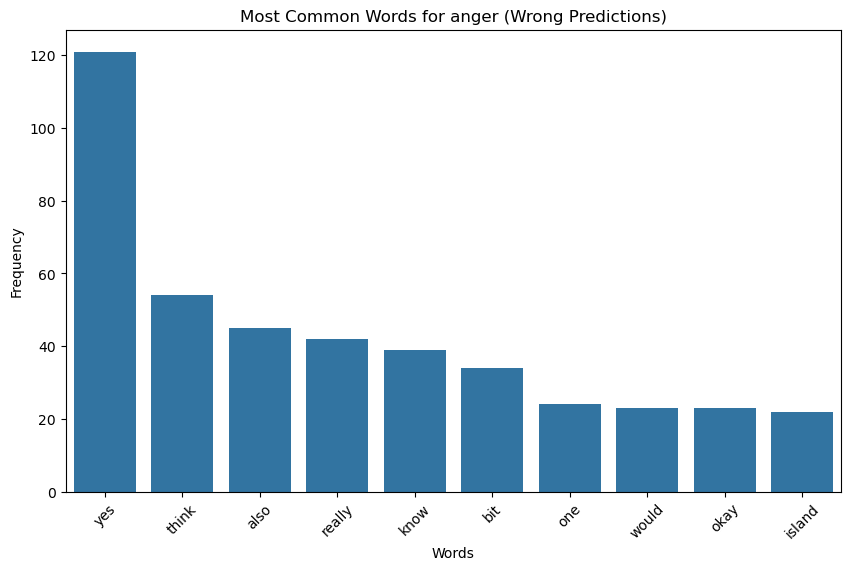

In [18]:
for emotion in true_emotions:
    word_frequency_analysis(merged_df, emotion, num_words=10, wrong_predictions=True)

## Sentence length analysis
Is there something about sentence length? 

In [19]:
def calculate_sentence_lengths(df):
    """
    Calculate the lengths of sentences in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the text data.

    Returns:
        pandas.DataFrame: The DataFrame with an additional column 'sentence_lengths' containing the lengths of sentences.

    """
    df['sentences'] = df['text'].apply(nltk.sent_tokenize)
    df['sentence_lengths'] = df['sentences'].apply(lambda sentences: [len(nltk.word_tokenize(sentence)) for sentence in sentences])
    
    return df

In [20]:
def plot_sentence_length_distribution(df):
    """
    Plots the distribution of sentence lengths for each emotion in the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    """
    emotions = df['true_emotion'].unique()

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    for i, emotion in enumerate(emotions):
        row = i // 3
        col = i % 3
        
        subset = df[df['true_emotion'] == emotion]
        true_subset = subset[subset['predictions'] == emotion]
        false_subset = subset[subset['predictions'] != emotion]
        
        true_lengths = [length for lengths in true_subset['sentence_lengths'] for length in lengths]
        false_lengths = [length for lengths in false_subset['sentence_lengths'] for length in lengths]
        
        true_hist, true_bins = np.histogram(true_lengths, bins=20, density=True)
        false_hist, false_bins = np.histogram(false_lengths, bins=20, density=True)
        
        sns.histplot(true_lengths, bins=true_bins, kde=True, ax=axes[row, col], color='blue', label='True Predictions')
        sns.histplot(false_lengths, bins=false_bins, kde=True, ax=axes[row, col], color='red', label='False Predictions')
        
        axes[row, col].set_title(f'Distribution of Segment Lengths for {emotion}')
        axes[row, col].set_xlabel('Sentence Length (Tokens per sentence)')
        axes[row, col].set_ylabel('Normalized Frequency')
        axes[row, col].legend()
        axes[row, col].set_xlim(0, 1500)
        
    plt.tight_layout()
    plt.show()

c:\Users\r_bor\anaconda3\envs\ml-gpu\lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


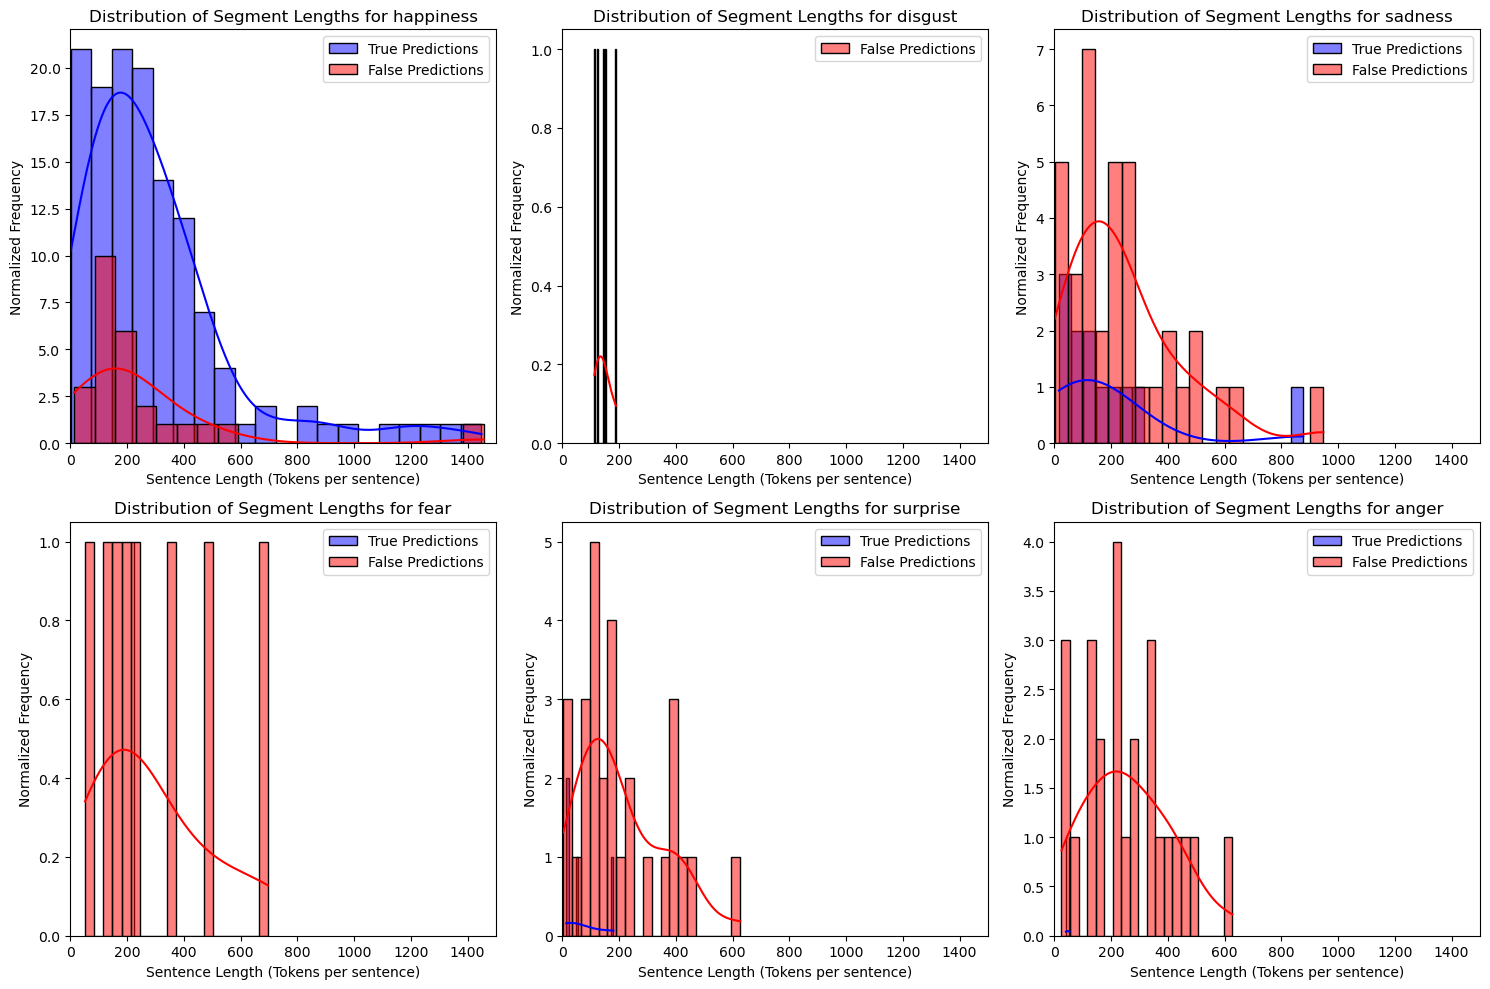

In [21]:
merged_df = calculate_sentence_lengths(merged_df)
plot_sentence_length_distribution(merged_df)

## Confusion matrix analysis 
Are all sentences of class x predicted as class y? 

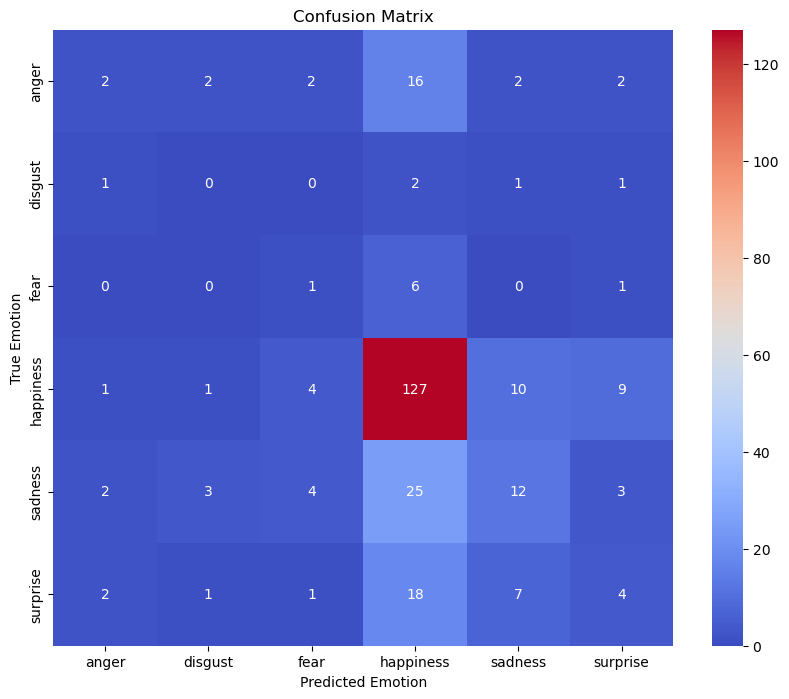

In [22]:
# Create a confusion matrix
confusion_matrix = pd.crosstab(merged_df['true_emotion'], merged_df['predictions'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, cmap="coolwarm", annot=True, fmt='d')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.show()


## Evaluation metric importance
For the task at hand, is a high accuracy, recall or F1 score more important?

In [23]:
accuracy = accuracy_score(merged_df['true_emotion'], merged_df['predictions'])
recall = recall_score(merged_df['true_emotion'], merged_df['predictions'], average='weighted')
f1 = f1_score(merged_df['true_emotion'], merged_df['predictions'], average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5347985347985348
Recall: 0.5347985347985348
F1 Score: 0.4942940994589879


In [24]:
# Calculate metrics for each unique emotion
unique_emotions = merged_df['true_emotion'].unique()
for emotion in unique_emotions:
    emotion_df = merged_df[merged_df['true_emotion'] == emotion]
    accuracy_emotion = accuracy_score(emotion_df['true_emotion'], emotion_df['predictions'])
    recall_emotion = recall_score(emotion_df['true_emotion'], emotion_df['predictions'], average='weighted')
    f1_emotion = f1_score(emotion_df['true_emotion'], emotion_df['predictions'], average='weighted')
    
    print(f"\nMetrics for {emotion}:")
    print("Accuracy:", accuracy_emotion)
    print("Recall:", recall_emotion)
    print("F1 Score:", f1_emotion)


Metrics for happiness:
Accuracy: 0.8355263157894737
Recall: 0.8355263157894737
F1 Score: 0.910394265232975

Metrics for disgust:
Accuracy: 0.0
Recall: 0.0
F1 Score: 0.0

Metrics for sadness:
Accuracy: 0.24489795918367346
Recall: 0.24489795918367346
F1 Score: 0.39344262295081966

Metrics for fear:
Accuracy: 0.125
Recall: 0.125
F1 Score: 0.2222222222222222

Metrics for surprise:
Accuracy: 0.12121212121212122
Recall: 0.12121212121212122
F1 Score: 0.21621621621621626

Metrics for anger:
Accuracy: 0.07692307692307693
Recall: 0.07692307692307693
F1 Score: 0.14285714285714288


c:\Users\r_bor\anaconda3\envs\ml-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\r_bor\anaconda3\envs\ml-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\r_bor\anaconda3\envs\ml-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\r_bor\anaconda3\envs\ml-gpu\lib\site-packages\sklearn\metrics\_classifica

In [25]:
confusion_matrix = pd.crosstab(merged_df['true_emotion'], merged_df['predictions'])

# Calculate false positives for each emotion
false_positives = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)

# Calculate false negatives for each emotion
false_negatives = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)

# Print the false positives and false negatives
for i, emotion in enumerate(confusion_matrix.index):
    print(f"Emotion: {emotion}")
    print(f"False Positives: {false_positives[i]}")
    print(f"False Negatives: {false_negatives[i]}")

Emotion: anger
False Positives: 6
False Negatives: 24
Emotion: disgust
False Positives: 7
False Negatives: 5
Emotion: fear
False Positives: 11
False Negatives: 7
Emotion: happiness
False Positives: 67
False Negatives: 25
Emotion: sadness
False Positives: 20
False Negatives: 37
Emotion: surprise
False Positives: 16
False Negatives: 29


C:\Users\r_bor\AppData\Local\Temp\ipykernel_8152\1732266544.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"False Positives: {false_positives[i]}")
C:\Users\r_bor\AppData\Local\Temp\ipykernel_8152\1732266544.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"False Negatives: {false_negatives[i]}")


## Text Feature Importance LIME Analysis​

In [26]:
# create subset using only disgust
disgust_df = merged_df[merged_df['predictions'] == 'disgust']

In [27]:
# create strings for each segment
segments = disgust_df['text'].unique()

segment1 = segments[0]
segment2 = segments[1]
segment3 = segments[2]

In [28]:
# Load BERT model
model = TFBertForSequenceClassification.from_pretrained('model')

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define emotion labels
labels = merged_df['true_emotion'].unique()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [29]:
def predict_emotion(texts):
    """
    Predicts the emotion for a given list of text.
    
    Args:
        texts (list): A list of strings containing the text
        
    Returns:
        numpy.ndarray: An array of containing the predicted probabilities of each emotion for each text.
    """
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
    outputs = model(inputs)
    probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()
    return probs

In [30]:
explainer = LimeTextExplainer(class_names=labels)

In [44]:
# Generate explanation
exp = explainer.explain_instance(segment1, predict_emotion, num_features=6, top_labels=3)

# Plot explanation
exp.show_in_notebook(text=segment1)